<a href="https://colab.research.google.com/github/chrisjmccormick/llm-tuning-examples/blob/main/sentence-classification/Fine-Tune%20an%20LLM%20for%20Sentence%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ▂▂▂▂▂▂▂▂▂▂▂▂

# LLM Fine-Tuning for Sentence Classification

By Chris McCormick

I've been curious to see just how well these enormous LLMs perform at traditional NLP tasks such as classifying text.

In this Notebook, I've taken my original "BERT for Sequence Classification" example and swapped out the 110M parameter BERT for the _8 billion_ parameter Llama 3.1.

It's not a simple drop-in replacement, though:

1. There are some techniques we'll need to employ in order to be able to fine-tune an LLM on a free Colab GPU without running out of memory.
2. To get decent performance, you'll want to add a prompt to your dataset.

I'll take us through each of these changes in this tutorial.



_Seeing "Under the Hood"_

One of my favorite aspects of the original Notebook was that it It implements the training loop in PyTorch rather than relying on the HuggingFace Trainer class, which I feel tends to hide too much of what's going on, so I've kept that aspect of the Notebook and updated it.

It still uses HuggingFace for the model implementation and weights, and for tokenizing.



# How to Apply An LLM

There are some different approaches you can take to classifying text with a language model (i.e., a "Decoder" model) like GPT or Llama.

In this Notebook, we'll be doing it by:

1. Adding a "few-shot" prompt to our text,
2. Choosing words to represent our class labels, and
3. Classifying the input using Llama 3.1's existing language modeling head to predict the label word.

To see why this is a good choice, let's start with a brief overview of how Decoder models work, and then look at the problem with the simpler "just classify the last token in the sequence" approach.

**Decoder Models**


A Decoder model like Llama 3 processes one token at a time, and caches what it learns about it.

It starts with looking up the **embedding** for the current input token, and then sends this through 24 "decoder" layers.

> _An "embedding" is just an array of values--4,096 of them in the case of Llama 3. The values are a bunch of (very precise) fractions, and taken together they store information relevant to our task._

Each layer "enriches" the embedding with a little more of what we need--a layer gathers information by looking back over the input text, and incorporates that into the embedding.

<img src='https://lh3.googleusercontent.com/d/1QD1pTMeQ3F6XwK03lbeUk45CuUZv28Py' alt='Inner Workings of An LLM' width='900' />

As it moves through the layers, the embedding goes from representing the current **input word**, to becoming an embedding that resembles the **next token** to predict!

> _Fun fact: When you multiply and sum up each of the values in two word embeddings, the result is a measure of the similarity between the words!_

**Adding a Classifier Head**

To classify the text, you could add a simple linear classifier (it's just 4,096 weight values, same as the embedding) which you apply to the final output embedding in the sequence.

> _This is what the "LlamaForSequenceClassification" class in HuggingFace does for you, but we'll be going a different direction._



<img src='https://lh3.googleusercontent.com/d/1Myo8C4Xp_wdMd6o2N4Qd2G6dqUeG4_I4' alt='Adding linear classifier' width='800' />

**Without Prompting...**

We _could_ stop here, and fine-tune our model without touching our dataset--I've seen it done in other examples.

Think about what's happening in that approach, though...

The original model was trained to predict the next token, and doesn't know that we want it to evalute the input text for grammatical correctness.

So, at least initially, that output embedding contains little-to-no information relevant to our intended task.

We'll have to fine-tune on enough training data to change Llama 3 from a "next token predictor" into a "grammar evaluator".

That's certainly possible, but we can get better results with much less data if we're willing to add a prompt to the input text.

**Prompting**

We know that LLM's are already quite good at all kinds of tasks if you just explain and/or demonstrate the desired behavior in the prompt (i.e., "few shot prompting").

We can craft a prompt to add to our input which will encourage the model to predict a token representing the correct class label. This will be a much better starting point for fine-tuning!


**Our Initial Prompt**

We're going to use the Llama 3 "base model" (as opposed to the "instruction-tuned" version which has been trained to behave more like an assistant).

With the base model, I learned that it's best to prompt it by simply creating a pattern, like:

```
Me and him went to the store. - unacceptable
Him and I went to the store. - acceptable
The gardener watered the flowers. - acceptable
I didn't eat any ice cream and any cake. -
```

With such a clear pattern, even if the model predicts the wrong answer, it's still very likely to output an embedding that resembles either "acceptable" or "unacceptable".



<img src='https://lh3.googleusercontent.com/d/1UwhdmEfZQBbwHUxNWLf-rSTl3rlgwOT6' alt='Adding a few-shot prompt' width='800' />

Distinguishing between those two word embeddings is an easy task for a linear classifier--it shouldn't take much training to start getting decent results.

And now as we further fine-tune the LLM, we're not fighting against its original behavior of next token prediction!

**Leveraging the LM Head**

Of course, LLMs _already include_ the ability to say whether "acceptable" or "unacceptable" is most likely!

This is performed by the model's "language modeling head" (LM head) for performing next token prediction.

> _"Language modeling" is literally "modeling all of human language" by understanding the propbabilties.  

The LM head is actually just a huge table of word embeddings (one for every token in the vocabulary), just like the vocabulary of input embeddings used at the beginning of the model.



<img src='https://lh3.googleusercontent.com/d/1a0tDHIU-nLgC9_lnDvsts0lvw2vIuXVY' alt='Predicting a class label with an LLM' width='800' />

When generating text, to predict the next token we **multiply** the **output embedding** with every word embedding in the **LM head**, giving us a score for each and every token in the model's vocabulary.

These scores represent how likely the model thinks each one could be the next word.

For our purposes, we can just look specifically at the scores for the words we've chosen to represent our **class labels** and choose whichever one has the **higher confidence**.

(And note how this conveniently avoids any problems around the model predicting a word that's not one of our class labels!)

Because of how intelligent these models have become, this approach of prompting and classifying with the LM head gives very strong results on our task, _even without any fine-tuning_.

_Side Note: Why not use the same word embeddings for the input and output?_

It _is_ possible to tie the input and output vocabularies together during pre-training so that we only need one table (which, in the case of Llama 3, would save us _half-a-billion_ parameters 😳). However, it's standard practice (so presumably works better?) to allow the model to learn separate tables for the input and output.

**Crafting the Prompt**

It makes sense that thinking about your wording and defining a task more clearly in the prompt will improve performance, particularly when your task is rather complicated.

In the example in this notebook, though, the task is very straightforward, and I was surprised to see just how big of an impact prompt engineering made, despite all of the different prompts being equally clear (it seemed to me) about what the objective was.

While some of the prompt selection is just trial and error, there _are_ some very important subtleties to the tokenization process to pay close attention to, and I'll cover those.

Let's dive into the code!

# ▂▂▂▂▂▂▂▂▂▂▂▂

# S1. Setup

## 1.1. Install Packages

In [ ]:
import time

# Track the total time to run all of the package installations.
t0 = time.time()

Many HuggingFace packages are installed by default in Colab, but here are some we'll need:

In [ ]:
# Required for using 4-bit quantization (to make our model fit in the GPU
# memory!) and the 8-bit optimizer (which helps with running training on the
# limited memory of the free T4 GPU).
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.2 MB/s eta 0:00:00


The HuggingFace `peft` library implements LoRA for us, an important piece for fine-tuning.

In [ ]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 8.6 MB/s eta 0:00:00


## 1.2. Llama Access

One small annoyance here is that, in order to use recent LLMs like Llama 3.1, you'll need to accept a license agreement for the model, and then perform a login step here so that HuggingFace knows you've done that.

1. Create a huggingface account (it's free).
2. Go to the model page and fill out the form:
    * https://huggingface.co/meta-llama/Meta-Llama-3-8B
    * I didn't get access immediately, but I had access when I came back to check two hours later. You can check status [here](https://huggingface.co/settings/gated-repos), and I also received an email notification.
3. Create an "access token" in your account settings:
    * Go to your [token settings](https://huggingface.co/settings/tokens) and click "New Token":

<center><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/hub/new-token.png" width="500px" alt_text="Create a new token"/>

(Image is from the HuggingFace docs, <a href="(https://huggingface.co/docs/hub/en/security-tokens">here</a>)</center>

* You can name it **hf_hub_all_notebooks**, and the **read** Role is sufficient.

4. Add it to the **Secrets** panel in Colab (the key symbol in the sidebar to the left).
    * Click the checkbox to give your notebook access to the key.
5. Finally, run the code below to log in to HuggingFace!



In [ ]:
from google.colab import userdata

# I used the "secrets" panel in Colab and defined the variable
# "hf_hub_all_notebooks" and set it to my personal huggingface key.
# You could just paste in your key directly here if this is a private copy.
hf_api_key = userdata.get('hf_hub_all_notebooks')

!huggingface-cli login --token $hf_api_key

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## 1.3. GPU

The settings for this Notebook depend a bit on your choice of GPU. This example runs quite comfortably on the A100 or L4, but the free T4 is more constraining...

If you're running on the T4, we'll use the "8-bit optimizer", and possibly gradient accumulation depending on your maximum sequence length.




We'll use a function from PyTorch to get some details on the GPU you're using.

In [ ]:
import torch

# There's a nice function now for retrieving the GPU info...
gpu_stats = torch.cuda.get_device_properties(0)

print(f"GPU = {gpu_stats.name}.")

# A key attribute is the amount of memory, in GB, the GPU has, so let's
# calculate that by dividing the total bytes by 2^30.
gpu_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU Memory = {gpu_memory} GB")

# Finally, we'll store a shorthand version of the name and use this as a switch
# for other settings (e.g., if gpu = "T4", then ...)
if "T4" in gpu_stats.name:
    gpu = "T4"

elif "L4" in gpu_stats.name:
    gpu = "L4"

elif "A100" in gpu_stats.name:
    gpu = "A100"

else:
    raise ValueError(f"Unsupported GPU: {gpu_stats.name}")

print("Shorthand Name:", gpu_stats.name, ' -->', gpu )

GPU = Tesla T4.
GPU Memory = 14.748 GB
Shorthand Name: Tesla T4  --> T4


## 1.4. Helper Functions

`format_time`

For printing out how long certain steps took.

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
print("All of that package installation stuff took:", format_time(time.time() - t0))

All of that package installation stuff took: 0:00:17


`format_size`

This helper function prints out big numbers nicely using base 2 magnitudes (i.e., K = 2^10, M = 2^20, B = 2^30)

In [ ]:
def format_size(num):
    """
    This function iterates through a list of suffixes ('K', 'M', 'B') and
    divides the input number by 1024 until the absolute value of the number is
    less than 1024. Then, it formats the number with the appropriate suffix and
    returns the result. If the number is larger than "B", it uses 'T'.
    """
    suffixes = ['', 'K', 'M', 'B']
    base = 1024

    for suffix in suffixes:
        if abs(num) < base:
            if num % 1 != 0:
                return f"{num:.2f}{suffix}"

            else:
                return f"{num:.0f}{suffix}"

        num /= base

    # Use "T" for anything larger.
    if num % 1 != 0:
        return f"{num:.2f}T"

    else:
        return f"{num:.0f}T"



`format_lr_as_multiple`

Learning rates are usually something times 10^-4 or 10^-5. I've started to display them as multiples of the smallest typical value--1e-5.

I think that makes it a lot easier to understand the relative size of the different lr values.

In [ ]:
def format_lr_as_multiple(lr):
    # Convert the learning rate into a multiple of 1e-5.
    multiple = lr / 1e-5

    # Return the formatted string.
    return "{:.1f} x 1e-5".format(multiple)

`gpu_mem_used`

This function uses the "NVIDIA System Management Interface" `nvidia-smi` command line tool to retrieve the current memory usage.

There's a function in PyTorch, `torch.cuda.memory_allocated()`, but it seems to severely under-report. 🤷‍♂️

In [ ]:
import os
import torch

def gpu_mem_used():
    """
    Returns the current GPU memory usage as a string, e.g., "5.02 GB"
    """

    # This approach doesn't work, because PyTorch only tracks its own memory
    # usage, not the total memory consumption of the GPU.
    #gpu_bytes_used = torch.cuda.memory_allocated()

    # Run the nvidia-smi command line tool to get memory used in megabytes.
    buf = os.popen('nvidia-smi --query-gpu=memory.used, --format=csv,noheader,nounits')

    # It returns an unformated integer number of "MiB" (2^20 bytes).
    gpu_mb_used = float(buf.read())

    # Divide that by 1024 to get GB.
    mem_used = gpu_mb_used / float(1024)

    return ("{0:.2f} GB".format(mem_used))


In [ ]:
print("GPU memory used: {:}".format(gpu_mem_used()))

GPU memory used: 0.00 GB


# ▂▂▂▂▂▂▂▂▂▂▂▂

# S2. Loading CoLA Dataset


We're comparing LLM performance to my original BERT Notebook, which used [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE" Benchmark.

## 2.1. Download & Extract

We'll use the `wget` package to download the dataset to the Colab instance's file system.

In [ ]:
# (Not installed by default)
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=141f23cd1eb8ec1c7f61d7e0a90630b1c3d65485191ceb05896a23c0a1f6006c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


The dataset is hosted on GitHub in this repo: https://nyu-mll.github.io/CoLA/

In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Unzip the dataset to the file system. You can browse the file system of the Colab instance in the sidebar on the left.

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available.

We can't use the pre-tokenized version because, in order to apply an LLM, we *must* use the tokenizer provided by the model--it has a specific vocabulary of tokens that it can accept.

We'll use pandas to parse the "in-domain" data (the training set) and look at a few of its properties and data points.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv(
    "./cola_public/raw/in_domain_train.tsv",
    delimiter = '\t',
    header = None,
    names = ['sentence_source', 'label', 'label_notes', 'sentence']
)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
3151,l-93,1,NaN,Sharon shivered.
4187,ks08,1,NaN,Some of the record contains evidence of wrongd...
7517,sks13,1,NaN,Mary wrote a letter to him last year.
7220,sks13,0,*,It is arrive tomorrow that Mary will.
8371,ad03,1,NaN,The wizard turned the beetle into beer with a ...
8385,ad03,1,NaN,I looked the number up.
3683,ks08,1,NaN,John suddenly put the customers off.
599,bc01,1,NaN,The kettle bubbled water.
2191,l-93,1,NaN,The statue stood on the pedestal.
5984,c_13,1,NaN,Alex was eating the popsicle.


The two properties we actually care about are the the `sentence` and its `label`, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).

Here are five sentences which are labeled as not grammatically acceptible. Note how much more difficult this task is than something like sentiment analysis!

In [ ]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
7894,No reading Shakespeare satisfied me,0
244,I wonder you ate how much.,0
2154,Terry touched at the cat.,0
2790,Steve pelted acorns to Anna.,0
430,It's probable in general that he understands w...,0


Also, note that this dataset is highly imbalanced--let's print out the number of positive vs. negative samples:

In [ ]:
# Since the positive samples have the label value "1", we can sum them to count
# them.
num_positive_samples = df.label.sum()

num_samples = len(df.label)

prcnt_positive = float(num_positive_samples / num_samples) * 100.0

print(
    "Number of positive samples: {:,} of {:,}. {:.3}%".format( \
    num_positive_samples, num_samples, prcnt_positive)
)


Number of positive samples: 6,023 of 8,551. 70.4%




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

# S3. Prompting & Label Words

As covered in the intro, the prompt and label words are key to our success.

In this section, we'll look at how the tokenizer handles our prompt and label word choices.

Then we'll add the prompt and label words to our data.


## 3.1. Tokenizer



To feed our text to an LLM, it must be split into tokens, and then these tokens must be mapped to their index in the model's vocabulary.

The tokenization must be performed by the tokenizer included with Llama--the below cell will download this for us.


In [ ]:
from transformers import LlamaTokenizer
from transformers import AutoTokenizer
from transformers import LlamaTokenizerFast

# Load the tokenizer.
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Let's apply the tokenizer to one sentence just to see the output.

IMPORTANT: The Llama tokenizer distinguishes words and subwords by a leading space. (For Mistral, the token string contains a space. For Llama, it's 'Ġ'. 🙄 In both cases, though, your input just needs a leading ' ').

In [ ]:
# IMPORTANT: Add the leading space to the sentence!
example_sen = ' ' + sentences[0]

# Print the original sentence.
print(' Original: ', example_sen)

tokens = tokenizer.tokenize(example_sen)

# Print the sentence split into tokens.
print('Tokenized: ', tokens)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Print the sentence mapped to token ids.
print('Token IDs: ', token_ids)

 Original:   Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['ĠOur', 'Ġfriends', 'Ġwon', "'t", 'Ġbuy', 'Ġthis', 'Ġanalysis', ',', 'Ġlet', 'Ġalone', 'Ġthe', 'Ġnext', 'Ġone', 'Ġwe', 'Ġpropose', '.']
Token IDs:  [5751, 4885, 2834, 956, 3780, 420, 6492, 11, 1095, 7636, 279, 1828, 832, 584, 30714, 13]


* Here are some interesting properties to check out of any tokenizer that you work with.

In [ ]:
# Assume tokenizer is your LlamaTokenizer instance
tokenizer_properties = {
    'name_or_path': tokenizer.name_or_path,
    'vocab_size': tokenizer.vocab_size,
    'model_max_length': tokenizer.model_max_length,
    'is_fast': tokenizer.is_fast,
    'padding_side': tokenizer.padding_side,
    'truncation_side': tokenizer.truncation_side,
    'clean_up_tokenization_spaces': tokenizer.clean_up_tokenization_spaces,
    'bos_token': tokenizer.bos_token,
    'eos_token': tokenizer.eos_token,
    'unk_token': tokenizer.unk_token,
    'sep_token': tokenizer.sep_token,
    'pad_token': tokenizer.pad_token,
    'mask_token': tokenizer.mask_token,
}

# Print each property in a formatted way
for key, value in tokenizer_properties.items():
    print(f"{key.rjust(30)}:  {value}")


                  name_or_path:  meta-llama/Meta-Llama-3-8B
                    vocab_size:  128000
              model_max_length:  1000000000000000019884624838656
                       is_fast:  True
                  padding_side:  right
               truncation_side:  right
  clean_up_tokenization_spaces:  True
                     bos_token:  <|begin_of_text|>
                     eos_token:  <|end_of_text|>
                     unk_token:  None
                     sep_token:  None
                     pad_token:  None
                    mask_token:  None


**Tokenizer Settings**

Padding our samples with a "pad token" is important for batching our inputs to the model (all the samples in a batch need to be the same length, so we have to pad them).

We provide the model with an attention mask to ensure that it doesn't attend to the pad tokens (though, with an LLM, the real tokens can't look ahead to the padding anyway!)

Since the pad tokens aren't incorporated into the interpretation of the text, it doesn't actually matter which token we use, and Llama doesn't even have one defined. We just need to pick something, so we'll use the eos_token.

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

## 3.2. Choosing Label Words


Some thoughts:

* Choose words that make sense for the task to leverage the LLM's understanding.
* For CoLA, they use the language gramattically "acceptable" or "unacceptable" rather than "correct" or "incorrect".
* This notebook won't support multi-token label words--you could probably do it if you think through the changes carefully.
* Again, to treat the labels as whole words, you'll need to include the leading space.

Let's see how the tokenizer handles our labels!


In [ ]:
print("Token representations of our label words:")

print("    ' acceptable' = ", tokenizer.tokenize(' acceptable'))
print("  ' unacceptable' = ", tokenizer.tokenize(' unacceptable'))

Token representations of our label words:
    ' acceptable' =  ['Ġacceptable']
  ' unacceptable' =  ['Ġunacceptable']


Out of curiosity, here are "correct" and "incorrect".

In [ ]:
print("Token representations of our label words:")

print("    ' correct' = ", tokenizer.tokenize(' correct'))
print("  ' incorrect' = ", tokenizer.tokenize(' incorrect'))

Token representations of our label words:
    ' correct' =  ['Ġcorrect']
  ' incorrect' =  ['Ġincorrect']


There's a very useful tool here for quickly viewing the tokens in a nicely formatted way:

https://huggingface.co/spaces/Xenova/the-tokenizer-playground


**Subwords vs. Words**

* SentencePiece tokenizers can reconstruct text fully.
* Full words are distinguished from sub words using a leading space.
* Llama 3 has a ~4x larger vocabulary than the previous generation (Llama 2 and Mistral 7b).

* If you ommit the leading space they will be treated as subtokens, and may not actually have the meaning you intended!


In [ ]:
print("Token representations if we forget the leading space:")

print("    'acceptable' = ", tokenizer.tokenize("acceptable"))
print("  'unacceptable' = ", tokenizer.tokenize("unacceptable"))

Token representations if we forget the leading space:
    'acceptable' =  ['acceptable']
  'unacceptable' =  ['un', 'acceptable']


We're using acceptable and unacceptable.

The labels now have three representations:

1. The class label, 0 or 1
2. The token string, " unacceptable" or " acceptable"
3. The token id, 44085, 22281

At various points we'll need to map between them, so I've created some dictionaries for that.

In [ ]:
label_val_to_word = {}
label_val_to_token_id = {}

pos_token_id = -1
neg_token_id = -1

# Select our word for the positive label (1)
label_val_to_word[1] = ' acceptable'

# Show it as a token.
pos_token = tokenizer.tokenize(label_val_to_word[1])[0]
print(pos_token)

# Lookup and store its token id.
pos_token_id = tokenizer.convert_tokens_to_ids(pos_token)
label_val_to_token_id[1] = pos_token_id
print(str(pos_token_id) + '\n')

# Select our word for the negative label (0)
label_val_to_word[0] = ' unacceptable'

# Show it as a token.
neg_token = tokenizer.tokenize(label_val_to_word[0])[0]
print(neg_token)

# Look up and store its token id.
neg_token_id = tokenizer.convert_tokens_to_ids(neg_token)
label_val_to_token_id[0] = neg_token_id
print(str(neg_token_id) + '\n')



Ġacceptable
22281

Ġunacceptable
44085



## 3.3. Crafting Our Prompt

I'll share some prompts I tried and the scores they got in order to illustrate a few points.

Note that, because the CoLA dataset is imbalanced (with more 'acceptable' sentences than 'unacceptable'), the official metric is the Matthews Correlation Coefficient (MCC), which is designed to account for this.



**Mistral vs. Llama 3**

Here's the first prompt variation that I tried.

```python
""" Classify this sentence as grammatically acceptable or unacceptable: Him and me are going to the store.
A: unacceptable

Classify this sentence as grammatically acceptable or unacceptable: Him and I are going to the store.
A: acceptable

Classify this sentence as grammatically acceptable or unacceptable: {sentence}
A:{label_word}"""
```

1. This scored an MCC value of `0.522` using Mistral 7B.

2. Simply switching to **Llama 3.1** raised this by **0.023** to `0.545`.



**Leading Spaces and Label Quotes**

I made a few more changes, explained below, and arrived at the following:

```python
""" Classify the grammar of this sentence as ' acceptable' or ' unacceptable': Him and me are going to the store.
 A: unacceptable

 Classify the grammar of this sentence as ' acceptable' or ' unacceptable': Him and I are going to the store.
 A: acceptable

 Classify the grammar of this sentence as ' acceptable' or ' unacceptable': {sentence}
 A:{label_word}"""
 ```

1. The previous prompt is missing the **leading spaces** on each new line, and fixing that increased the score by **0.011** up to `0.556`.

2. Adding **single quotes** around the the label words had the _biggest impact_ of anything I tried! It increased the score by **0.076** up to `0.632`.

3. I was curious if adding a leading space to the label words _inside the quotes_ would help--it did make a small difference of 0.006, bringing the score to 0.638.

**Instructions vs. Patterns**

I learned that when using the base model (`meta-llama/Meta-Llama-3-8B`), as opposed to the instruction-tuned version (`meta-llama/Llama-3.1-8B-Instruct`), it's best to create a simple pattern rather than telling it what to do.

(It did still help a little, though, to provide some context as well) Here's what I landed on for the prompt in this notebook:

```python
""" Examples of sentences that are grammatically ' acceptable' or ' unacceptable':
 Him and me are going to the store. - unacceptable
 Him and I are going to the store. - acceptable
 {sentence} -{label_word}"""
```

This increased the score by **0.009** to `0.647`.

## 3.4. Add Prompts & Labels

We can define our prompt as a template (as a formatting string), and then loop over the samples to apply the template.

Note that we're adding labels to the entire training set, and doing it prior to splitting off a validation set...

But that's ok! When predicting the next token, the LLM can't attend to future tokens, so it can't "see" the label. And we want the label there anyway so that we can measure the validation loss.

In [ ]:
prompt_template = \
""" Examples of sentences that are grammatically ' acceptable' or ' unacceptable':
 Him and me are going to the store. - unacceptable
 Him and I are going to the store. - acceptable
 {sentence} -{label_word}"""

In [ ]:
labeled_sentences = []
labels_as_ids = []

# For each sentence in the dataset...
for i in range(len(sentences)):

    sentence = sentences[i]
    label_val = labels[i]

    # Map the numerical label (0, 1) to the word we chose.
    label_word = label_val_to_word[label_val]

    # Look up the token id for the label.
    label_id = label_val_to_token_id[label_val]

    # Insert the sample and its label into the template.
    labeled_sentence = prompt_template.format(
        sentence = sentence,
        label_word = label_word
    )

    # Add to our new lists.
    labeled_sentences.append(labeled_sentence)
    labels_as_ids.append(label_id)


Let's check out a couple formatted examples.

It can be difficult to recognize in the output window, but each line begins with a leading space.

In [ ]:
print("\"{:}\"".format(labeled_sentences[0]))

" Examples of sentences that are grammatically ' acceptable' or ' unacceptable':
 Him and me are going to the store. - unacceptable
 Him and I are going to the store. - acceptable
 Our friends won't buy this analysis, let alone the next one we propose. - acceptable"


In [ ]:
print("\"{:}\"".format(labeled_sentences[1]))

" Examples of sentences that are grammatically ' acceptable' or ' unacceptable':
 Him and me are going to the store. - unacceptable
 Him and I are going to the store. - acceptable
 One more pseudo generalization and I'm giving up. - acceptable"


**Subsample Dataset**

In [ ]:
# If you want to quickly test out your code, you can slice this down to just a
# small subset.

#labeled_sentences = labeled_sentences[:500]
#labels_as_ids = labels_as_ids[:500]

# S4. Format Training Data

## 4.1. Tokenize

Tokenize and encode all of the sentences.

**Padding for Batching**

* Training on batches of, e.g., 16 samples at once is an important part of achieving good accuracy. The weight updates are averaged over the batch, leading to smoother training steps.
* It also makes better use of the GPU's parallelism and speeds things up substantially.
* It introduces a problem, though... The batch is presented as a single tensor, so the dimensions of all 16 samples need to be the same.
* We address this by adding garbage to the end, and specifying an input attention mask which zeros out the influence of those tokens on the weight updates.

* Our label words will be at a different spot for each sample, depending on its length. We can look at the attention mask to easily locate them.


Some of the parameters I'm setting here correspond to the defaults, but I like being explicit.

> A little side rant: It kinda drives me nuts how the `transformers` library hides so many details of the process via optional parameters which are set to default values.
>
> Worse, it often "looks up" the default value by referencing some model-specific code, which makes it hard to track down the actual values in the documentation.

In [ ]:
# The tokenizer is a "callable object"--this invokes its __call__ function,
# which will tokenize and encode all of the input strings.
encodings = tokenizer(

    labeled_sentences, # List of strings.

    padding = 'longest',  # Pad out all of the samples to match the longest one
                          # in the data.

    #max_length = 64,      # An alternative strategy is to specify a maximum
    #padding='max_length', # length, but it makes sense to let the tokenizer
                           # figure that out.

    truncation = False, # These samples are too short to need truncating. If we
                        # did need to truncate, we'd also need to specify the
                        # max_length above.

    add_special_tokens = True, # Add the bos and eos tokens.

    return_attention_mask = True, # To distinguish the padding tokens.

    return_tensors = "pt" # Return the results as pytorch tensors.
)


#### ⚙️ Max Sequence Length

This is a critical number when it comes to the memory and compute requirements on the GPU.

Compute is "quadratic" with sequence length (i.e., sequence length squared).

Memory use would be quadratic, too, but some clever tricks have been found to avoid that, and now it's just linear.

Still, going from, e.g., 64 tokens to 512 is going to make things 8x worse! 😳

With the prompt I've chosen, the maximum sequence length is 86 in the training data. On the T4, I just barely got a batch size of 8 to fit at this length.

Also, note that training is much more memory-intensive than inference, so you can get away with a longer sequence length during inference.

In [ ]:
max_seq_len = len(encodings['input_ids'][0])

print("Longest training sequence length:", max_seq_len)

Longest training sequence length: 86


## 4.2. Define Targets

The tokenizer gave us the token ids and attention masks.

For building our dataset, let's also store the locations of our label words.

Also, in order to train an LLM on next token prediction, you give it both the input text and the desired output text.

Typically these are identical--you're giving the model text and training it to reproduce it.

Here, though, we don't need to mess with the model's ability to generate text in general--we just want to improve its ability to predict our label words in the appropriate spot.

To do this, we set the token IDs for all of the output text to -100, _except_ for our label word.

This sentinel value tells the code not to update the model for these tokens.

It's not quite the same as an attention mask--we still want the model to process the input tokens so that the model can see and attend to them (i.e., pull information from them) during training.


In [ ]:
# I'll add the prefix 'all' to these variables, since they still contain both
# the training and validation data.
all_input_ids = []
all_attention_masks = []
all_target_words = []
all_label_ids = []
all_label_pos = []

# For each of the encoded samples...
for i in range(len(labels_as_ids)):

    # Extract input_ids and attention_mask
    input_ids = encodings['input_ids'][i]
    attention_mask = encodings['attention_mask'][i]

    # Find the position of the last non-padding token using the attention mask
    # Because we appended the label to the end of the input, this is the
    # position of our label word.
    label_position = attention_mask.nonzero()[-1].item()

    # This will tell the model what to token to predict at each position.
    # (i.e., at position 12, the model should predict target_words[12])
    # You can set the value to -100 for any tokens you don't want to train on,
    # and in our case, we only want to train on the label.
    # Start by filling it all out with -100s
    target_words = torch.full_like(input_ids, -100)  # Initialize all labels to -100

    # Get the token id for the label
    label_id = labels_as_ids[i]

    # We want all of the words / tokens masked out, except for the label.
    target_words[label_position] = label_id

    # Store everything.
    all_input_ids.append(input_ids)
    all_attention_masks.append(attention_mask)
    all_target_words.append(target_words)
    all_label_pos.append(label_position)
    all_label_ids.append(label_id)



## 4.3. Split Dataset


We'll split off 10% of our data to use as a validation set. By testing against the validation set periodically during training, we can create a plot at the end to show us whether the model was overfitting the training data. (i.e., performance on the training set kept improving, but performance on the validation set got worse).

In [ ]:
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(all_input_ids))
val_size = len(all_input_ids) - train_size

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


7,695 training samples
  856 validation samples


Combine all of the data into a TensorDataset object.

Use torch.stack to convert the lists of vectors into matrices.


In [ ]:
import torch
from torch.utils.data import TensorDataset

# Convert the lists into PyTorch tensors and put into a TensorDataset object

dataset = TensorDataset(
    # These variables are currently lists of vectors. `stack` will combine
    # the vectors into a matrix with shape
    #   8551 x 123 ([number of samples] x [sequence length])
    torch.stack(all_input_ids),
    torch.stack(all_attention_masks),
    torch.stack(all_target_words),

    # These are lists, and need to be vectors.
    torch.tensor(all_label_ids),
    torch.tensor(all_label_pos)
)

# For reference, this is how we'll unpack a batch:
#     input_ids = batch[0]
#     attn_masks = batch[1]
#     targets = batch[2]
#     label_ids = batch[3]
#     label_pos = batch[4]

Before making the random split, let's set the seed value for consistent results.

In [ ]:
import numpy as np
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Now we can use the `random_split` function from PyTorch to randomly shuffle our dataset, and then split it into the two parts.

In [ ]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## 4.4. ⚙️ Batch Size

The final data preparation step is to wrap it in a PyTorch DataLoader, which will handle selecting batches for us. This means it's time to choose our training batch size!

Our batch size can be a big issue for fitting training into a GPU's memory, because the memory use grows linearly with the batch size.

Being forced to use smaller batches means less parallelism and slower training, but more importantly we miss out on the mathematical advantages and get a lower quality model!



**Mathematical Batch vs. GPU Batch**

However, things aren't actually quite that bleak, because the parallelism benefit and the mathematical benefit can be separated.

The mathematical benefit of batching comes from averaging our weight update across multiple samples for a smoother training step. If we only have enough memory to process, i.e., 1 sample at a time on the GPU, that just means we have to run multiple forward passes and **accumulate the gradients** before we update the model weights.

So really there are two separate parameters to choose:

1. The **mathematical batch size** - What batch size do we want to use for averaging our updates?

2. The **GPU batch size** - How many samples can we run in parrallel on the GPU without running out of memory.

A third, implied parameter is the number of GPU passes to make per batch.


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it
# here.

# First, specify the mathematical batch size that we want.
train_batch_size = 8

# Second, specify the number of samples we want to give to the GPU at a time.
# (We set this to a lower number if we're running out of memory)

# Because our sequence length is so short, we can actually manage to use our
# full batch size of 8 even on the 15GB T4--just barely!
# If you try out a longer prompt, though, you may go over.
if gpu == "T4" and max_seq_len > 90:
    gpu_batch_size = 4
# If you run this notebook as-is, then this size will work on all devices:
else:
    gpu_batch_size = 8

# These must be evenly divisible.
assert(train_batch_size % gpu_batch_size == 0)

# Calculate how many batches to accumulate the gradients over.
accumulate_passes = int(train_batch_size / gpu_batch_size)

print("For the math, we are using an (effective) batch size "\
      "of {:}.".format(train_batch_size))
print("For memory constraints, we will only give the GPU {:} samples at " \
      "a time.".format(gpu_batch_size))
print("We'll do this by accumulating the gradients over {:} GPU " \
      "passes before updating.".format(accumulate_passes))

For the math, we are using an (effective) batch size of 8.
For memory constraints, we will only give the GPU 8 samples at a time.
We'll do this by accumulating the gradients over 1 GPU passes before updating.


> <font color="olive" size="-1"><strong>Aside:</strong></font>
>
> <font size="-1">If you use the HuggingFace Trainer class (which I think you should avoid! 😝), you'll see the mathematical batch size expressed indirectly as a combination of "device batch size" and "batch accumulation steps". I'm good with the first term, but not the second one... My biggest beef is that it confuses the definition of "steps"--using it to refer to GPU forward passes instead of actual optimizer/training steps.

In [ ]:
# When running inference, there's no need for accumulation.
val_batch_size = gpu_batch_size

# The A100 can handle a bigger batch size to make the validation go quicker.
if gpu == "A100":
    val_batch_size = 16

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset

# Create the DataLoaders for our training and validation sets.
# These will handle the creation of batches for us.
# Note that we want to use the GPU batch size here, not the effective one.

# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = gpu_batch_size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = val_batch_size # Evaluate with this batch size.
        )

Side Note: In this example, the dataset is plenty small enough that we can just load the whole thing into memory. For huge datasets, though, we have to leave them on disk, and the DataLoader also provides functionallity for loading just the current samples.

# ▂▂▂▂▂▂▂▂▂▂▂▂

# S5. Compress & Load The Model

We're ready to load the model onto the GPU!


**bfloat16**

One annoying little detail is that older architectures (including the T4) don't support the "bfloat16" data type, so we need to toggle between regular float16 and bfloat16 based on your GPU.


><font color='olive'><strong>Aside</strong></font>
>
> _The 'b' is for Google Brain, who introduced this data type specifically for deep learning._
>
> _Compared to float16, it can represent much huger and much tinier numbers, but with fewer distinct numbers in between._

In [ ]:
if gpu == "T4":
    torch_dtype = torch.float16
elif gpu == "L4" or gpu == "A100":
    torch_dtype = torch.bfloat16

**4-bit Quantization**

To get our 8B parameter Llama 3.1 model to fit in memory, we're going to compress the weight values ("quantize" them).

We'll use 4-bit quantization for this (from the "QLoRA" paper). Below is the configuration object for setting it up.

> <font color='olive'><strong>Aside</strong></font>
>
> _4-bit quantization is not the same as creating a 4-bit model--it's still 16-bit!_
>
> _Each parameter will be represented by a 4-bit value **multiplied by a 16-bit scaling factor** (stored to the side)._
>
> _That requires more memory, not less... The way we achieve compression is that every 64 parameters share the same 16-bit multiplier._
>
> _Kinda crazy, right? Check out my blog post [here](https://mccormickml.com/2024/09/14/qlora-and-4bit-quantization/) to learn how it works in-depth._

In [ ]:
import torch
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    # Enable 4-bit quantization.
    load_in_4bit = True,

    # With "double quantization" we not only compress the weights, we compress
    # the scaling factors as well!
    bnb_4bit_use_double_quant = False,

    # The authors did some analysis of the distribution of weight values in
    # popular transformer models, and chose some hardcoded values to use as the
    # 16 "base values". They are normally distributed around 0.
    # They refer to this as the "nf4" data type.
    #
    # The alternative choice is "float4", which only has 15 unique values, but
    # also seems to be normally distributed.
    bnb_4bit_quant_type = "nf4",

    # The 16-bit data type for the scaling factors and math.
    bnb_4bit_compute_dtype = torch_dtype

    # Note that the "block size" of 64, which determines the compression ratio,
    # doesn't appear to be configurable!
)

In [ ]:
# Tell PyTorch to use the GPU.
device = torch.device("cuda")

Download the model and run the 4-bit compression algorithm on it.

Note that, as discussed in the introduction, we're not using the "AutoModelForSequenceClassification" class, which adds a linear classifier. We're sticking with the original "CausalLM" class, which includes the LM head on the output.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

t0 = time.time()

# Load the model.
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",

    # Our 4-bit quantization setup defined in the previous section.
    quantization_config = bnb_config,

    # Squared Dot-Product Attention is the generic name for the key innovation
    # in FlashAttention. It's implemented in pytorch now. It's the default
    # value for this parameter.
    # You can change it to "eager" for the straightforward implementation if
    # you want to compare the two!
    attn_implementation = "sdpa",

    # I assume it's critical that this datatype match the one used in
    # the quantization configuration, and in LoRA!
    torch_dtype = torch_dtype,

    # I was getting this output message:
    #    "`low_cpu_mem_usage` was None, now set to True since model is
    #      quantized."
    # So I'm setting it to "True" as the message suggests. :)
    #
    # I tried setting it to False out of curiousity, and it crashed with:
    #    "Your session crashed after using all available RAM."
    low_cpu_mem_usage = True,

    # The model needs to know that we've set a pad token.
    pad_token_id = tokenizer.pad_token_id,
)

# Typically I would tell the model to run on the GPU at this point, but this
# actually throws an error:
#   "ValueError: Calling `cuda()` is not supported for `4-bit` or `8-bit`
#    quantized models. Please use the model as it is, since the model has
#    already been set to the correct devices and casted to the correct `dtype`."
#model.cuda()

print("\nDownloading, compressing, and loading took", format_time(time.time() - t0))

gpu_mem_model = gpu_mem_used()

print("\nGPU memory used to store model: {:}".format(gpu_mem_model))

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]


Downloading, compressing, and loading took 0:06:37

GPU memory used to store model: 5.85 GB


It's kinda interesting to check out the parameters after compression. The matrices get unrolled into 1D vectors, and two 4-bit values are packed into each byte, so the parameter counts are no longer accurate (they've been cut in half).



In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The model has {:} different named parameters.\n'.format(len(params)))

print("Parameter Name                                              Dimensions       Total Values    Trainable\n")

# For the first xx named parameters...
for i in range(len(params)):

    # First param is the embeddings
    if i == 0:
        print('==== Embedding Layer ====\n')

    # Next 10 parameters are the first decoder layer.
    elif i == 1:
        print('\n==== First Decoder ====\n')

    # Next 10 parameters are the second decoder layer.
    elif i == 10:
        print('\n==== Second Decoder ====\n')

    # Skip the other layers
    elif i >= 19 and i < len(params)-2:
        continue

    # Final 2 are the output layer.
    elif i == len(params)-2:
        print('\n==== Output Layer ====\n')

    # Get the name and the parameter.
    p_name, p = params[i]

    # Strip some unnecessary prefixes.
    if 'base_model.model.model.' in p_name:
        p_name = p_name[len('base_model.model.'):]


    # For 1D parameters, put '-' as the second dimension.
    if len(p.size()) == 1:
        p_dims = "{:>10,} x {:<10}".format(p.size()[0], "-")

    # For 2D parameters...
    if len(p.size()) == 2:
        p_dims = "{:>10,} x {:<10,}".format(p.size()[0], p.size()[1])

    # Print the parameter name, shape, number of elements, and whether it's been
    # 'frozen' or not.
    print("{:<55} {:}    {:>6}    {:}".format(p_name, p_dims, format_size(p.numel()), p.requires_grad))


The model has 291 different named parameters.

Parameter Name                                              Dimensions       Total Values    Trainable

==== Embedding Layer ====

model.embed_tokens.weight                                  128,256 x 4,096           501M    True

==== First Decoder ====

model.layers.0.self_attn.q_proj.weight                   8,388,608 x 1                 8M    False
model.layers.0.self_attn.k_proj.weight                   2,097,152 x 1                 2M    False
model.layers.0.self_attn.v_proj.weight                   2,097,152 x 1                 2M    False
model.layers.0.self_attn.o_proj.weight                   8,388,608 x 1                 8M    False
model.layers.0.mlp.gate_proj.weight                     29,360,128 x 1                28M    False
model.layers.0.mlp.up_proj.weight                       29,360,128 x 1                28M    False
model.layers.0.mlp.down_proj.weight                     29,360,128 x 1                28M    False
model

Note that the 16-bit scaling factors are stored separately from the model, so they're not reflected here.

Also, quantization has _not_ been applied to the input embeddings or to the output LM head. We could still fine-tune these if we wanted to.

For comparison, here are those same parameters if you don't apply quantization

```
The model has 291 different named parameters.

Parameter Name                                              Dimensions       Total Values    Trainable

==== Embedding Layer ====

model.embed_tokens.weight                                  128,256 x 4,096           501M    True

==== First Decoder ====

model.layers.0.self_attn.q_proj.weight                       4,096 x 4,096            16M    True
model.layers.0.self_attn.k_proj.weight                       1,024 x 4,096             4M    True
model.layers.0.self_attn.v_proj.weight                       1,024 x 4,096             4M    True
model.layers.0.self_attn.o_proj.weight                       4,096 x 4,096            16M    True
model.layers.0.mlp.gate_proj.weight                         14,336 x 4,096            56M    True
model.layers.0.mlp.up_proj.weight                           14,336 x 4,096            56M    True
model.layers.0.mlp.down_proj.weight                          4,096 x 14,336           56M    True
model.layers.0.input_layernorm.weight                        4,096 x -                 4K    True
model.layers.0.post_attention_layernorm.weight               4,096 x -                 4K    True

==== Second Decoder ====

model.layers.1.self_attn.q_proj.weight                       4,096 x 4,096            16M    True
model.layers.1.self_attn.k_proj.weight                       1,024 x 4,096             4M    True
model.layers.1.self_attn.v_proj.weight                       1,024 x 4,096             4M    True
model.layers.1.self_attn.o_proj.weight                       4,096 x 4,096            16M    True
model.layers.1.mlp.gate_proj.weight                         14,336 x 4,096            56M    True
model.layers.1.mlp.up_proj.weight                           14,336 x 4,096            56M    True
model.layers.1.mlp.down_proj.weight                          4,096 x 14,336           56M    True
model.layers.1.input_layernorm.weight                        4,096 x -                 4K    True
model.layers.1.post_attention_layernorm.weight               4,096 x -                 4K    True

==== Output Layer ====

model.norm.weight                                            4,096 x -                 4K    True
lm_head.weight                                             128,256 x 4,096
```

# S6. Evaluation Function

Let's define a function for evaluating our model on validation or test data.

We'll use this function in three places:

1. To test our performance prior to any fine-tuning.
2. To run validation during training.
3. To evaluate on the test set after training.

This is where we're implementing our classification strategy--we look at the logit values for just our two label words and compare these to make a prediction.

> <font color="olive" size="-1"><strong>Aside:</strong></font>
>
><font size="-1">I typically try to avoid splitting off important functionality into functions. You get a better sense of what's really going on when it's all laid out in one place (so you're not having to jump around to remember what different functions do). That may mean maintaining multiple copies of the same code, and yes, that can introduce errors when you forget to fix the copies--but misunderstanding the code can certainly introduce errors as well! In this case, it's a pretty big block of code, and I think it's conceptually distinct enough from the rest of the training loop that I don't feel too bad about separating it.


In [ ]:

def evaluate(model, validation_dataloader):
    """
    Run the model against a validation or test set and return a list of true
    labels and a list of predicted labels.
    """

    #t0 = time.time()

    batch_num = 0

    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Gather the true labels and predictions
    true_labels = []
    predictions = []

    # For each batch...
    for batch in validation_dataloader:

        # Print progress
        if batch_num % 40 == 0:
            print("  Batch {:>5,}  of  {:>5,}.".format(batch_num, len(validation_dataloader)))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.

        # These three all have the same shape of [batch_size x sequence_length]
        # e.g., [8 x 128]
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        targets = batch[2].to(device)
        true_label_ids = batch[3].to(device) # Shape: [8] (batch_size)
        label_positions = batch[4].to(device) # Shape: [8] (batch_size)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Get the model's predictions
            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask,
                labels = targets
            )

        # The output predictions for every token in the input.
        # Shape: [8, 128, vocab_size] (batch_size, sequence_length, vocab_size)
        logits = outputs.logits

        loss = outputs.loss
        total_loss += loss.item()

        # Extract the predicted token for each sample in the batch, one at a time.
        # For each sample in the batch...
        for i in range(input_ids.shape[0]):

            # The index of the final (non-padding) token.
            label_position = label_positions[i].item()

            # Extract logits for the prediction.
            # The logits for the position *just before* the label are the
            # predictions we want.
            # Shape: [vocab_size]
            label_logits = logits[i, label_position - 1]

            # Make our prediction by comparing the confidence for the two
            # label words.
            if label_logits[pos_token_id] > label_logits[neg_token_id]:
                predicted_token_id = pos_token_id
            else:
                predicted_token_id = neg_token_id

            # Append the true and predicted token IDs for comparison
            true_labels.append(true_label_ids[i].item())
            predictions.append(predicted_token_id)

        # Increment the batch counter
        batch_num += 1

    # Report the average validation loss, which we can use to compare to our
    # training loss and detect overfitting.
    avg_loss = total_loss / batch_num

    #print("\n  Validation took: {:}".format(format_time(time.time() - t0)))

    return(true_labels, predictions, avg_loss)

## 6.1. Few-Shot Performance

Because of our few-shot prompt, our model ought to perform fairly well on the task without any fine-tuning. Let's measure it's performance on the validation set as a baseline.

In [ ]:
print('Running validation...')

true_labels, predictions, avg_loss = evaluate(model, validation_dataloader)

Running validation...
  Batch     0  of    107.


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


  Batch    40  of    107.
  Batch    80  of    107.


Because of the class imbalance, the "flat accuracy" (num right / num samples) isn't a great metric.

The official metric for the benchmark is the Matthews Correlation Coefficient (MCC).

In [ ]:
import numpy as np

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

true_labels = np.asarray(true_labels)
predictions = np.asarray(predictions)

# Report the final accuracy for this validation run.
val_accuracy = float(np.sum(true_labels == predictions)) / len(true_labels) * 100.0
print("Flat accuracy: {0:.2f}%".format(val_accuracy))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print or log the confusion matrix
print("\nConfusion Matrix:\n")
print(conf_matrix)
print("")
print("  TP    FP")
print("  FN    TN")

# Measure the MCC on the validation set.
few_shot_mcc = matthews_corrcoef(true_labels, predictions)

print("\nMCC on the validation set without fine-tuning: {0:.3f}".format(few_shot_mcc))


Flat accuracy: 78.86%

Confusion Matrix:

[[463 133]
 [ 48 212]]

  TP    FP
  FN    TN

MCC on the validation set without fine-tuning: 0.555


In a separate Notebook, I also ran this few-shot performance on the test set.

* Without 4-bit quantization: MCC = `0.508`
* With 4-bit: `0.495`



Let's see how much memory it required to run some forward passes.

In [ ]:
# Get the current GPU memory, which will reflect how much memory is required
# to store the activation values.
gpu_mem_forward_pass = gpu_mem_used()

print("\nGPU memory used for forward passes: {:}".format(gpu_mem_forward_pass))
print(
    "(With GPU batch size {:} and sequence length {:})".format(val_batch_size,
                                                               len(encodings['input_ids'][0]))

)


GPU memory used for forward passes: 7.59 GB
(With GPU batch size 8 and sequence length 86)


# S7. Adding LoRA

The compressed model values can't be trained--any updates to the values would require re-running the compression algorithm.

LoRA adds on a small number of additional weights that we _can_ train.

But more importantly, LoRA also serves as a form of "regularization"--it limits how much we can change the model during fine-tuning. This is important for avoiding over-fitting our small training set.

In [ ]:
from peft import LoraConfig

# This is the key parameter. Think of it like the number of neurons you're
# using in each hidden layer of a neural network. More will allow for
# bigger changes to the model behavior but require more training data.
lora_rank = 8

# LoRA multiplies the gradients by a scaling factor, s = alpha / rank.
# When you double the rank, the size gradients of the gradients tend to double
# as well, so `s` is used to scale them back down.
# If you want to play with different rank values, you can keep alpha constant in
# order to maintain the same (effective) scaling factor.
#
# An oddity here is that `s` is redundant with the learning rate... both are
# just multipliers applied to the gradients.
# They could have addressed this instead by saying, e.g., "when doubling the
# rank, it's suggested that you cut the learning rate in half"
lora_alpha = 16

lora_config = LoraConfig(
    r = lora_rank,

    lora_alpha = lora_alpha,

    lora_dropout = 0.05,

    # The original convention with LoRA was to apply it to just the Query and
    # Value matrices. An important contribution of the QLoRA paper was that it's
    # important (and not very costly) to apply it to "everything" (the attention
    # matrices and the FFN)
    #target_modules=["q_proj", "v_proj"],
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    bias="none",

    # This is a crucial parameter that I missed when initially trying to use the
    # LlamaForSequenceClassification class. I couldn't figure out why my model
    # wasn't learning, until I discovered that LoRA was freezing the parameters
    # of the linear classifier head!
    task_type="CAUSAL_LM"
)

In [ ]:
from peft import get_peft_model

# Wrap with PEFT Model applying LoRA
model = get_peft_model(model, lora_config).to(device)

# Tell pytorch to run this model on the GPU.
model.cuda()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128001)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
     

In [ ]:
# This is a bad idea / doesn't work when mixed with quantization.
# Also misleading about what LoRA is for.
#model.print_trainable_parameters()

In [ ]:
gpu_mem_lora = gpu_mem_used()
print("\nGPU memory used after adding LoRA: {:}".format(gpu_mem_lora))


GPU memory used after adding LoRA: 7.67 GB


Let's peek at the architecture again now that LoRA's been added.

We can see all of the A, B matrices added by LoRA. They have the dimensions of the embedding size and our chosen rank.

Note that by default LoRA freezes the embeddings and the LM head.



In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The model has {:} different named parameters.\n'.format(len(params)))

print("Parameter Name                                              Dimensions       Total Values    Trainable\n")

# For the first xx named parameters...
for i in range(len(params)):

    # First param is the embeddings
    if i == 0:
        print('==== Embedding Layer ====\n')

    # Next 24 parameters are the first decoder layer.
    elif i == 1:
        print('\n==== First Decoder ====\n')

    # Next 24 parameters are the second decoder layer.
    elif i == 24:
        print('\n==== Second Decoder ====\n')

    # Skip the other layers
    elif i > 46 and i < len(params)-2:
        continue

    # Final 2 are the output layer.
    elif i == len(params)-2:
        print('\n==== Output Layer ====\n')

    # Get the name and the parameter.
    p_name, p = params[i]

    # Strip some unnecessary prefixes.
    if 'base_model.model.model.' in p_name:
        p_name = p_name[len('base_model.model.'):]

    # For 1D parameters, put '-' as the second dimension.
    if len(p.size()) == 1:
        p_dims = "{:>10,} x {:<10}".format(p.size()[0], "-")

    # For 2D parameters...
    if len(p.size()) == 2:
        p_dims = "{:>10,} x {:<10,}".format(p.size()[0], p.size()[1])

    # Print the parameter name, shape, number of elements, and whether it's been
    # 'frozen' or not.
    print("{:<55} {:}    {:>6}    {:}".format(p_name, p_dims, format_size(p.numel()), p.requires_grad))


The model has 739 different named parameters.

Parameter Name                                              Dimensions       Total Values    Trainable

==== Embedding Layer ====

model.embed_tokens.weight                                  128,256 x 4,096           501M    False

==== First Decoder ====

model.layers.0.self_attn.q_proj.base_layer.weight        8,388,608 x 1                 8M    False
model.layers.0.self_attn.q_proj.lora_A.default.weight            8 x 4,096            32K    True
model.layers.0.self_attn.q_proj.lora_B.default.weight        4,096 x 8                32K    True
model.layers.0.self_attn.k_proj.base_layer.weight        2,097,152 x 1                 2M    False
model.layers.0.self_attn.k_proj.lora_A.default.weight            8 x 4,096            32K    True
model.layers.0.self_attn.k_proj.lora_B.default.weight        1,024 x 8                 8K    True
model.layers.0.self_attn.v_proj.base_layer.weight        2,097,152 x 1                 2M    False
model.la

# ▂▂▂▂▂▂▂▂▂▂▂▂

# S8. Training

## 8.1. Optimizer & Learning Rate Scheduler

### ⚙️ Learning Rate

The number of different settings involved in training can be overwhelming, but you definitely want to pay attention to the **learning rate** and **batch size**. These can have a big impact on performance, and you should experiment with them.


**What is the Learning Rate?**

As part of training, the calculated **weight updates** are **scaled down**(dramatically!) by multiplying them with the learning rate.

In general, smaller batch sizes need smaller learning rates, and vice versa:

* Roughly speaking, a larger batch size can produce more accurate weight updates--you're averaging the updates over more samples in order to make a more educated guess about which direction to move in.

* Larger learning rates (e.g., 1e-4) mean bigger changes to the model at each step. And if your weight updates are more accurate (from averaging over a larger batch), then it's safe to be more aggressive (with a higher learning rate) in making changes.

...but you can also end up watering down the influence of each training sample with too large of a batch size.

So, in the end, it's best to just sweep over a bunch of possible combinations! 😝

I didn't do a thorough parameter sweep, but a batch size of 8 and a learning rate of 1e-4 gave me the best results out of what I tried.

**What's an 8-bit Optimizer?**

The Adam optimizer applies weight updates in a more complicated way than the simple update function I learned in Machine Learning 101.

The math's a bit complicated, but roughly speaking, it adjusts the weight updates with information from prior updates in order to smooth things out overall.

It needs to store multiple additional values for every parameter in the model, and the 8-bit optimizer applies a compression technique to store these.

Just like the 4-bit quantization we applied to our model earlier, this is _not the same_ as dropping the optimizer precision to 8-bits--there is additional higher precision metadata stored in order to return the values to (16-bits?) before they're used.

In [ ]:
import bitsandbytes as bnb
from transformers import AdamW

# Note that the LoRA ratio has a linear impact on the lr, so with 16/8,
# 1e-4 is effectively 2e-4.
lr = 1e-4

# At these lower sequence lengths, the 8-bit optimizer makes a significant
# difference.
if gpu == 'T4':
    #optimizer_class = bnb.optim.PagedAdamW8bit
    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = AdamW

# Create the optimizer
optimizer = optimizer_class(

    model.parameters(), # The optimizer is responsible for making the updates to
                        # to our model parameters.
    lr = lr,

    weight_decay = 0.05, # Weight decay (related to regularization)
)


The learning rate scheduler is responsible for gradually decreasing the learning rate over the course of training.

In [ ]:
from transformers import get_linear_schedule_with_warmup
import math

# len(train_dataloader) gives us the number of GPU batches the data loader will
# divide our dataset into.
num_gpu_batches = len(train_dataloader)

# We need to divide the number of GPU batches by the number of accumulation
# passes to get the true number of update steps.
# Round up since there may be one partial batch at the end.
num_update_steps = math.ceil(num_gpu_batches / accumulate_passes)

# Our LoRA weights are completely random at first, so the initial gradients will
# be large. To counter this, we do some warmup steps with a tiny learning rate,
# gradually building up to the actual lr. Then the scheduler takes over.
num_warmup_steps = 100

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = num_warmup_steps,
    num_training_steps = num_update_steps
)


In [ ]:
# Without batch accumulation...

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
#total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
#scheduler = get_linear_schedule_with_warmup(
#    optimizer,
#    num_warmup_steps = 100,
#    num_training_steps = total_steps
#)

## 8.2. Training Loop

Below is our training loop. There's a lot going on, but here's the summary:

**Training:**

We take one batch at a time from the data loader, move it to the GPU, and execute:

1. `forward()` - Run the samples through the model to get predictions.

2. `loss.item()` - Retrieve the "loss", a measure of how poorly the model did on these samples.
3. `backward()` - Starting from the output, work backwards to calculate how much each parameter contributed to the loss, (the "deltas") and the derivative of those deltas (the "gradients").
4. `optimizer.step()` - Update the weights using the Adam formula by combining the learning rate, gradients, and those other stored smoothing values.

**Validation:**

Periodically, we'll check to see how we're doing on that 10% of the data we set aside for validation.

If we're continuing to improve on the training data, but see our performance on the validation set start to decrease, then we know we're starting to overfit.


We're ready to kick off the training!

In [ ]:
import random
import numpy as np
from sklearn.metrics import confusion_matrix

# Set the seed value again to make sure this is reproducible--the data
# loader will select the same random batches every time we run this.
seed_val = 42

# Set it all over the place for good measure.
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
t0 = time.time()

total_train_loss = 0

# Track the current step (because gradient accumulation means that this is
# different than the number of forward passes on the GPU).
optim_step = 0

# Put the model into training mode. `dropout` and `batchnorm` layers behave
# differently during training vs. test.
model.train()

# ========================================
#               Training
# ========================================

# Perform one full pass over the training set.
print('Training...\n')

print(
"'step' refers to one optimizer step (an important distinction if you're \
using gradient accumulation).\n"
)

# Print the header row for status updates.
print("{:>10}  {:>10}  {:>10}  {:>12}  {:>10}  {:>12}".format(
    "Step", "of Total", "Elapsed", "Loss", "GPU Mem", "lr"))

# For each GPU batch of training data...
for gpu_batch_i, batch in enumerate(train_dataloader):

    # ===================
    #    Forward Pass
    # ===================

    # Unpack this training batch from our dataloader.
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels -- In this case, these are target words at each
    #                  position.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Perform a forward pass (evaluate the model on this training batch).
    # In PyTorch, calling `model` will in turn call the model's `forward`
    # function and pass down the arguments.
    # Specifically, we'll get the loss (because we provided labels) and the
    # "logits"--the model outputs prior to activation.
    result = model(
        b_input_ids,
        attention_mask = b_input_mask,
        labels = b_labels
    )

    loss = result.loss
    logits = result.logits

    # Accumulate the training loss over all of the batches.
    # Note that the loss is already averaged over the GPU batch size!
    total_train_loss += loss.item()

    # =======================
    #     Backward Pass
    # =======================

    # Further scale the loss by the number of accumulation passes
    loss = loss / accumulate_passes

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Perform optimizer step after accumulating gradients.
    if ((gpu_batch_i + 1) % accumulate_passes == 0) or \
       ((gpu_batch_i + 1) == len(train_dataloader)):

        # Update the step count.
        optim_step += 1

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate according to the schedule.
        scheduler.step()

        # Clear the gradients.
        optimizer.zero_grad()

        # ======================
        #       Progress
        # ======================

        # Report every xx steps
        if optim_step % 10 == 0:

            # Calculate and format elapsed time.
            elapsed = format_time(time.time() - t0)

            # Display the learning rate as a multiple of 1e-5.
            lr_multiple = format_lr_as_multiple(scheduler.get_last_lr()[0])

            # Print the current row with values.
            print("{:>10,}  {:>10,}  {:>10}  {:>12.4f}  {:>10}  {:>12}".format(
                optim_step,
                num_update_steps,
                elapsed,
                total_train_loss / optim_step,
                gpu_mem_used(),
                lr_multiple
            ))

        # ====================
        #      Validation
        # ====================
        # Periodically measure our performance on our validation set.

        if optim_step % 200 == 0:

            print("")
            print("Running Validation...")

            val_t0 = time.time()

            # Run the validation dataset through the model.
            true_labels, predictions, avg_val_loss = evaluate(model, validation_dataloader)

            # Gather metrics...
            true_labels = np.asarray(true_labels)
            predictions = np.asarray(predictions)

            val_mcc = matthews_corrcoef(true_labels, predictions)

            print("\n  Validation MCC: {0:.2f}".format(val_mcc))

            # Measure how long the validation run took.
            validation_time = format_time(time.time() - val_t0)

            print("  Validation took: {:}".format(validation_time))

            # Record statistics.
            training_stats.append(
                {
                    'Step': optim_step,
                    'Training Loss': total_train_loss / (optim_step + 1),
                    'Valid. Loss': avg_val_loss,
                    'Valid. MCC': val_mcc,
                    'Training Time': format_time(time.time() - t0),
                    'Validation Time': validation_time
                }
            )

# =======================
#   Training Complete
# =======================

print("")
print("Training complete!")
print("")

# Calculate the average loss over all of the batches.
avg_train_loss = total_train_loss / num_update_steps

print("  Average training loss: {0:.4f}".format(avg_train_loss))

training_time = format_time(time.time() - t0)

print("  Training took: {:}".format(training_time))




Training...

'step' refers to one optimizer step (an important distinction if you're using gradient accumulation).

      Step    of Total     Elapsed          Loss     GPU Mem            lr
        10         962     0:00:19        0.6069    14.67 GB    1.0 x 1e-5
        20         962     0:00:38        0.5748    14.67 GB    2.0 x 1e-5
        30         962     0:00:57        0.5114    14.67 GB    3.0 x 1e-5
        40         962     0:01:16        0.4691    14.67 GB    4.0 x 1e-5
        50         962     0:01:35        0.5011    14.67 GB    5.0 x 1e-5
        60         962     0:01:53        0.4732    14.67 GB    6.0 x 1e-5
        70         962     0:02:13        0.4755    14.67 GB    7.0 x 1e-5
        80         962     0:02:31        0.4674    14.67 GB    8.0 x 1e-5
        90         962     0:02:50        0.5023    14.67 GB    9.0 x 1e-5
       100         962     0:03:09        0.4910    14.67 GB   10.0 x 1e-5
       110         962     0:03:28        0.5025    14.67 G

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Display the table.
df_stats

,Step,Training Loss,Valid. Loss,Valid. MCC,Training Time,Validation Time
0,200,0.4640,0.3687,0.6540,0:07:58,0:01:39
1,400,0.4414,0.4057,0.6467,0:15:44,0:01:39
2,600,0.4167,0.3740,0.6596,0:23:31,0:01:39
3,800,0.3883,0.3397,0.7007,0:31:17,0:01:39


(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is generally a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

In this situation, though, the validation MCC is likely better because of the class imbalance.

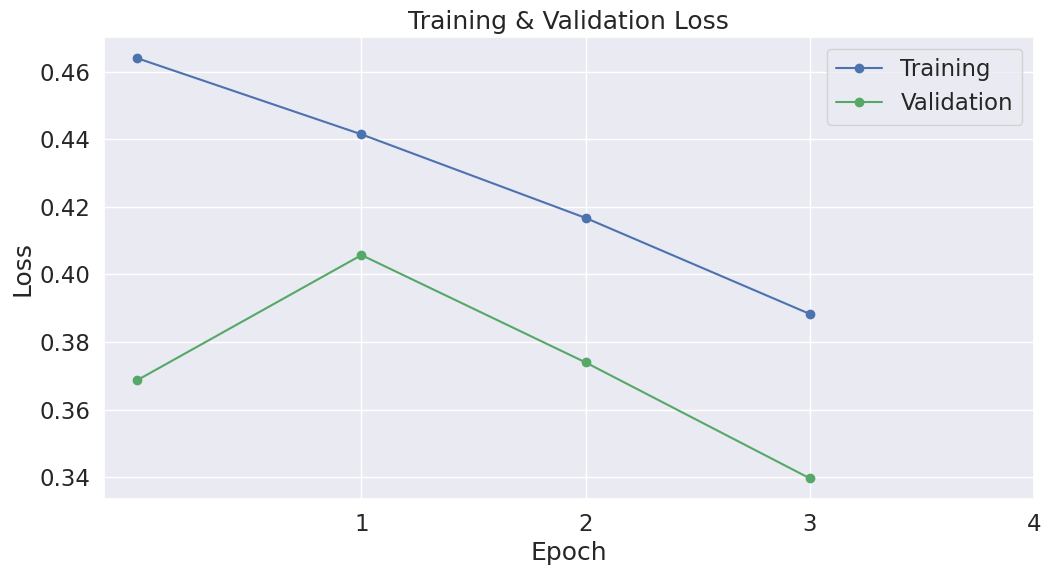

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# S9. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 9.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

**Step 1: Load the data file**

In [ ]:
import pandas as pd

# ======== Load Test Set ========

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values


Number of test sentences: 516



Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(),
                                               len(df.label),
                                            (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


**Step 2: Add prompt and labels**

In [ ]:
labeled_sentences = []
labels_as_ids = []

# For each sentence in the dataset...
for i in range(len(sentences)):

    sentence = sentences[i]
    label_val = labels[i]

    # Map the numerical label (0, 1) to the word we chose.
    label_word = label_val_to_word[label_val]

    # Look up the token id for the label.
    label_id = label_val_to_token_id[label_val]

    # Insert the sample and its label into the template.
    labeled_sentence = prompt_template.format(
        sentence = sentence,
        label_word = label_word
    )

    # Add to our new lists.
    labeled_sentences.append(labeled_sentence)
    labels_as_ids.append(label_id)


In [ ]:
print("Here's what they look like now:\n")
print("'{:}'".format(labeled_sentences[0]))


Here's what they look like now:

' Examples of sentences that are grammatically ' acceptable' or ' unacceptable':
 Him and me are going to the store. - unacceptable
 Him and I are going to the store. - acceptable
 Somebody just left - guess who. - acceptable'


**Step 4: Tokenize**

In [ ]:

# ======== Tokenize ========

# The tokenizer is a "callable object"--this invokes its __call__ function,
# which will tokenize and encode all of the input strings.
test_encodings = tokenizer(

    labeled_sentences, # List of strings.

    padding = 'longest',  # Pad out all of the samples to match the longest one
                          # in the data.

    #max_length = 64,      # An alternative strategy is to specify a maximum
    #padding='max_length', # length, but it makes sense to let the tokenizer
                           # figure that out.

    truncation = True, # Truncate any samples longer than the model's maximum
                       # sequence length.

    add_special_tokens = True, # Add the bos and eos tokens.
    return_token_type_ids = False, # These were used in BERT, but not in Mistral.
    return_attention_mask = True, # Mistral uses attention masks.

    return_tensors = "pt" # Return the results as pytorch tensors.
)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


**Step 5: Identify label positions and create masks**

In [ ]:
# I'll add the prefix 'all' to these variables, since they still contain both
# the training and validation data.
test_input_ids = []
test_attention_masks = []
test_target_words = []
test_label_ids = []
test_label_pos = []

# For each of the encoded samples...
for i in range(len(labels_as_ids)):

    # Extract input_ids and attention_mask
    input_ids = test_encodings['input_ids'][i]
    attention_mask = test_encodings['attention_mask'][i]

    # Find the position of the last non-padding token using the attention mask
    # Because we appended the label to the end of the input, this is the
    # position of our label word.
    label_position = attention_mask.nonzero()[-1].item()

    # This will tell the model what to token to predict at each position.
    # (i.e., at position 12, the model should predict target_words[12])
    # You can set the value to -100 for any tokens you don't want to train on,
    # and in our case, we only want to train on the label.
    # Start by filling it all out with -100s
    target_words = torch.full_like(input_ids, -100)  # Initialize all labels to -100

    # Get the token id for the label
    label_id = labels_as_ids[i]

    # We want all of the words / tokens masked out, except for the label.
    target_words[label_position] = label_id

    # Store everything.
    test_input_ids.append(input_ids)
    test_attention_masks.append(attention_mask)
    test_target_words.append(target_words)
    test_label_pos.append(label_position)
    test_label_ids.append(label_id)


Create our dataset and data loader for batching.

In [ ]:
test_dataset = TensorDataset(
    torch.stack(test_input_ids),
    torch.stack(test_attention_masks),
    torch.stack(test_target_words),
    torch.tensor(test_label_ids),
    torch.tensor(test_label_pos)
)

In [ ]:
# Set the batch size.
test_batch_size = gpu_batch_size

# Create the DataLoader.
prediction_sampler = SequentialSampler(test_dataset)

prediction_dataloader = DataLoader(
    test_dataset,
    sampler = prediction_sampler,
    batch_size = test_batch_size
)

## 9.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [83]:
print('Predicting labels for {:,} test sentences...'.format(len(test_encodings['input_ids'])))

true_labels, predictions, val_loss = evaluate(model, prediction_dataloader)

print('    DONE.')

Predicting labels for 516 test sentences...
  Batch     0  of     65.
  Batch    40  of     65.
    DONE.


In [ ]:
import numpy as np

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

true_labels = np.asarray(true_labels)
predictions = np.asarray(predictions)

# Report the final accuracy for this validation run.
val_accuracy = float(np.sum(true_labels == predictions)) / len(true_labels) * 100.0
print("Flat accuracy: {0:.2f}%".format(val_accuracy))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print or log the confusion matrix
print("\nConfusion Matrix:\n")
print(conf_matrix)
print("")
print("  TP    FP")
print("  FN    TN")

mcc = matthews_corrcoef(true_labels, predictions)

print("\nMCC: {0:.3f}".format(mcc))


Flat accuracy: 85.27%

Confusion Matrix:

[[331  23]
 [ 53 109]]

  TP    FP
  FN    TN

MCC: 0.647


A score of MCC = `64.7` is impressive!

For reference, my original [BERT example](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=ex5O1eV-Pfct) scores `51.4`.

The library documents the expected accuracy for this benchmark [here](https://huggingface.co/transformers/examples.html#glue) as `49.23`.

You can also look at the official leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy). However, it's not a fair comparison--I've found that training on the _entire_ training set (i.e., not removing 10% for validatio as we did here) gives the accuracy a big boost.

# ▂▂▂▂▂▂▂▂▂▂▂▂

# For funsies

In [74]:
# Let's see what you've got, Llama...
logic_test = """
 Llamas can output words. - Incorrect
 Llama 3.1 can output words. - Correct
 Llamas with version numbers output words. - Correct
 My pet llama, Tina, can talk. - Incorrect
 If I upgrade Tina to v3.1, she can talk. -
"""

# Tokenize the input
inputs = tokenizer(logic_test, return_tensors="pt")

# Generate the output from the model
outputs = model.generate(**inputs.to(device), max_new_tokens=1)

# Decode the generated tokens to text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the result
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



 Llamas can output words. - Incorrect
 Llama 3.1 can output words. - Correct
 Llamas with version numbers output words. - Correct
 My pet llama, Tina, can talk. - Incorrect
 If I upgrade Tina to v3.1, she can talk. -
 Incorrect


# GPU Memory Use

In [75]:
gpu_mem_train =  gpu_mem_used()

gpu_memory = "14.748 GB"

print("GPU Memory:", gpu_memory)
print("Compressed model:", gpu_mem_model)
print("Forward pass:", gpu_mem_forward_pass)
print("Adding LoRA:", gpu_mem_lora)
print("Training:", gpu_mem_train)

GPU Memory: 14.748 GB
Compressed model: 5.85 GB
Forward pass: 7.59 GB
Adding LoRA: 7.67 GB
Training: 14.68 GB


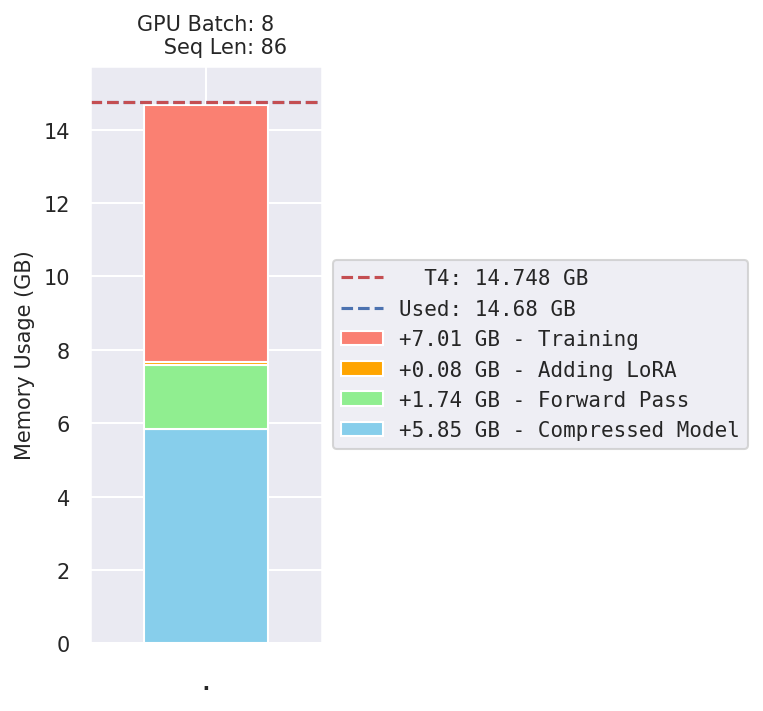

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the string values to floats
gm_model = float(gpu_mem_model.split()[0])
gm_forward_pass = float(gpu_mem_forward_pass.split()[0])
gm_lora = float(gpu_mem_lora.split()[0])
gm_train = float(gpu_mem_train.split()[0])
gm_total = float(gpu_memory.split()[0])

# Calculate the incremental memory added by each step
memory_additions = [
    gm_model,  # Compressed Model
    gm_forward_pass - gm_model,  # Forward Pass
    gm_lora - gm_forward_pass,   # Adding LoRA
    gm_train - gm_lora           # Training
]

# Update labels with memory added information
labels = [
    f'+{memory_additions[0]:.2f} GB - Compressed Model',
    f'+{memory_additions[1]:.2f} GB - Forward Pass',
    f'+{memory_additions[2]:.2f} GB - Adding LoRA',
    f'+{memory_additions[3]:.2f} GB - Training'
]

# Create a stacked bar plot with updated labels and proper y-limit
fig, ax = plt.subplots(figsize=(2, 5), dpi=150)  # Reduced figure width for a narrower bar, higher resolution

# Plot a horizontal line representing total used.
ax.axhline(y=gm_total, color='b', linestyle='--', label=f'Used: {gpu_mem_train}')

# Plot a horizontal line representing the total GPU memory available.
ax.axhline(y=gm_total, color='r', linestyle='--', label=f'{gpu:>4}: {gpu_memory}')

# Use a stacked bar chart where each bar adds to the total
ax.bar(".", memory_additions[0], label=labels[0], color='skyblue')
ax.bar(".", memory_additions[1], bottom=memory_additions[0], label=labels[1], color='lightgreen')
ax.bar(".", memory_additions[2], bottom=memory_additions[0] + memory_additions[1], label=labels[2], color='orange')
ax.bar(".", memory_additions[3], bottom=memory_additions[0] + memory_additions[1] + memory_additions[2], label=labels[3], color='salmon')


# Adjust the y-limit to make sure the total GPU memory line is visible
ax.set_ylim(0, gm_total + 1)  # Add some space above the total GPU memory

# Add labels and title
ax.set_ylabel('Memory Usage (GB)', fontsize=10)
ax.set_title('GPU Batch: {:}\n      Seq Len: {:}'.format(gpu_batch_size, len(encodings['input_ids'][0])), fontsize=10)

# Reverse the legend order to match the order of the bars, and move it outside the plot
handles, labels = ax.get_legend_handles_labels()

handles = list(reversed(handles))
reversed_labels = list(reversed(labels))

handles = handles[-2:] + handles[:-2]
reversed_labels = reversed_labels[-2:] + reversed_labels[:-2]

ax.legend(handles,
          reversed_labels,
          loc='center left', bbox_to_anchor=(1, 0.5),
          prop={'size': 10, 'family': 'monospace'})

# Adjust x-axis to make the single bar narrower visually
ax.set_xlim(-0.75, 0.75)

ax.tick_params(axis='y', labelsize=10)  # Adjust '8' to your desired font size

# Show the plot
plt.show()


# Logging Runs


### Summary of Run

In [77]:
from datetime import datetime

summary = {}

summary["Timestamp"] = datetime.now().strftime("%Y-%m-%d - %H:%M:%S")

summary["Model"] = "LLaMA 3 8B"

# ==== System ====
summary["GPU"] = gpu
summary["GPU Memory"] = gpu_memory
summary["GPU Memory Used"] = gpu_mem_used()
summary["Data Type"] = str(torch_dtype)
summary["Memory for Model"] = gpu_mem_model
summary["Memory after Forward Pass"] = gpu_mem_forward_pass
summary["Memory after Adding LoRA"] = gpu_mem_lora
summary["Memory after Training"] = gpu_mem_train

# ==== Training Parameters ====
summary["Maximum Sequence Length"] = len(encodings['input_ids'][0])
summary["Effective Batch Size"] = train_batch_size
summary["GPU Batch Size"] = gpu_batch_size
#summary["Accumulate Batches"] = accumulate_passes
summary["Gradient Checkpointing"] = False
summary["Optimizer"] = str(optimizer_class)
summary["Raw Learning Rate"] = lr
summary["Learning Rate"] = format_lr_as_multiple(lr)
summary["Learning Rate x LoRA"] = format_lr_as_multiple(
    lr * lora_config.lora_alpha / lora_config.r
)
# Include the ' to tell sheets to treat this as a literal string and include the
# surrounding quotes.
summary["Formatted Example"] = "'\"{:}\"".format(labeled_sentences[0])

#summary["Weight Decay"] = training_args.weight_decay
#summary["Scheduler"] = training_args.scheduler
#summary["Steps"] = training_args.max_steps

# ==== QLoRA Parameters ====
summary["LoRA r"] = lora_config.r
summary["LoRA alpha"] = lora_config.lora_alpha
summary["LoRA Dropout"] = lora_config.lora_dropout
#summary["LoRA Targets"] = lora_config.target_modules
summary["Quantization"] = "4-bit"

num_records = len(df_stats)

# ==== Results ====
summary["Training Loss"] = df_stats['Training Loss'][num_records - 1]
#summary["Valid. Loss"] = df_stats['Valid. Loss'][epochs]
summary["Training time"] = training_time
summary["MCC"] = mcc
summary["Few-Shot MCC"] = few_shot_mcc


# Convert the summary dictionary to a DataFrame
summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])

summary_df

,Metric,Value
0,Timestamp,2024-10-23 - 14:38:10
1,Model,LLaMA 3 8B
2,GPU,T4
3,GPU Memory,14.748 GB
4,GPU Memory Used,14.68 GB
5,Data Type,torch.float16
6,Memory for Model,5.85 GB
7,Memory after Forward Pass,7.59 GB
8,Memory after Adding LoRA,7.67 GB
9,Memory after Training,14.68 GB


### Summary Spreadsheet

Install Required Libraries: Ensure you have the necessary libraries installed in your Colab environment.

In [78]:
!pip install gspread

Authenticate and Access Google Sheets: You need to authenticate and access your Google Sheets. Use the following code to authenticate your Google account and open the Google Sheet.

In [79]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [80]:
# Open the Google Sheet by its id
# This is 'Fine-Tuning StackLLaMA - Run Summaries'
all_sheets = gc.open_by_key("1-EaX_HjYxZSU6BwJ1WT2eEC41nIYGeWoIjlYfD09_0s")

# Second sheet is for this CoLA notebook
sheet = all_sheets.worksheets()[1]

In [81]:
all_sheets.worksheets()

[<Worksheet 'sheet1' id:0>,
 <Worksheet 'sheet2' id:1366635988>,
 <Worksheet 'Sheet3' id:1814563296>]

Prepare the Data: Convert your summary dictionary into a format that can be appended to the Google Sheet.

Append the Data to Google Sheets: Read the existing data, determine the next available column, and append the new summary data.

In [82]:
import pandas as pd

# Read the existing data in the sheet
existing_data = sheet.get_all_values()
existing_df = pd.DataFrame(existing_data)

# Determine the next available column
next_col = len(existing_df.columns) + 1

# Append the summary data to the sheet
for index, row in summary_df.iterrows():

    # Find the 0-indexed row number for this metric from the summary table.
    index_obj = existing_df[existing_df[0] == row['Metric']].index

    # If the index object is empty, the metric wasn't found.
    if len(index_obj) == 0:
        print("Metric not found:", row['Metric'])

    else:
        # The spreadsheet row number is 1-indexed.
        sheet_row = index_obj[0] + 1

        print(row['Metric'], '   ', row['Value'])

        # Update the cell in the next available column
        sheet.update_cell(sheet_row, next_col, row['Value'])


Timestamp     2024-10-23 - 14:38:10
Model     LLaMA 3 8B
GPU     T4
GPU Memory     14.748 GB
GPU Memory Used     14.68 GB
Data Type     torch.float16
Memory for Model     5.85 GB
Memory after Forward Pass     7.59 GB
Memory after Adding LoRA     7.67 GB
Memory after Training     14.68 GB
Maximum Sequence Length     86
Effective Batch Size     8
GPU Batch Size     8
Gradient Checkpointing     False
Optimizer     <class 'bitsandbytes.optim.adamw.AdamW8bit'>
Raw Learning Rate     0.0001
Learning Rate     10.0 x 1e-5
Learning Rate x LoRA     20.0 x 1e-5
Formatted Example     '" Examples of sentences that are grammatically ' acceptable' or ' unacceptable':
 Him and me are going to the store. - unacceptable
 Him and I are going to the store. - acceptable
 Somebody just left - guess who. - acceptable"
LoRA r     8
LoRA alpha     16
LoRA Dropout     0.05
Quantization     4-bit
Training Loss     0.38831224773845374
Training time     0:36:15
MCC     0.6465701736731001
Few-Shot MCC     0.55523955